# Bayesian Interleaved and Accelerated Randomized Benchmarking


In [1]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
#from IPython import display

#Import Qiskit classes
import qiskit
from qiskit.tools.monitor import job_monitor
from qiskit import Aer
from qiskit.providers.aer.noise import NoiseModel
from qiskit import  QuantumRegister, QuantumCircuit
#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

# import the bayesian packages
import pymc3 as pm
import arviz as az

import bayesian_fitter as bf

In [2]:
# initialize the Bayesian extension
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Parameters of the RB Run <a name='select_params_RB'></a>


- **nseeds:** The number of seeds. For each seed you will get a separate list of output circuits in rb_circs.
- **length_vector:** The length vector of Clifford lengths. Must be in ascending order. RB sequences of increasing length grow on top of the previous sequences.
- **rb_pattern:** A list of the form [[i,j],[k],...] which will make simultaneous RB sequences where Qi,Qj are a 2-qubit RB sequence and Qk is a 1-qubit sequence, etc. The number of qubits is the sum of the entries. For 'regular' RB the qubit_pattern is just [[0]],[[0,1]].
- **length_multiplier:** If this is an array it scales each rb_sequence by the multiplier.
- **seed_offset:** What to start the seeds at (e.g. if we want to add more seeds later).
- **align_cliffs:**  If true adds a barrier across all qubits in rb_pattern after each set of cliffords.

In [3]:
RB_process = "3_Q RB"

if RB_process in ["3_Q RB","2-3_Q RB"] :
    #Number of qubits
    nQ = 3
    #There are 3 qubits: Q0,Q1,Q2.
    #2Q RB on Q0,Q2 and 1Q RB on Q1
    rb_pattern = [[1,2],[3]] # because 3 qubits
    #Do three times as many 1Q Cliffords    
    length_multiplier = [1,3]
    #Interleaved Clifford gates (2-qubits and 1-qubit)
    interleaved_gates = [['cx 0 1'],['x 2']]

else:
    #Number of qubits
    nQ = 2
    #There are 2 qubits: Q0,Q1.
    #2Q RB Q0,Q1
    rb_pattern = [[1,2]]
    length_multiplier = 1
    interleaved_gates = [['cx 0 1']]    

#Number of Cliffords in the sequence (start, stop, steps)
nCliffs = np.arange(1,200,20)
#Number of seeds (random sequences)
nseeds=8

scale = (2 ** len(rb_pattern[0]) - 1) / (2 ** len(rb_pattern[0]))

In [4]:
qregs_02 = QuantumRegister(2)
circ_02 = QuantumCircuit(qregs_02, name='circ_02')
#circ_02.h(qregs_02[0]) # booptrap! WIP!
circ_02.cx(qregs_02[0], qregs_02[1])
circ_02.draw()

q0_0: ──■──
      ┌─┴─┐
q0_1: ┤ X ├
      └───┘

In [5]:
qregs_1 = QuantumRegister(1)
circ_1 = QuantumCircuit(qregs_1, name='circ_1')
circ_1.x(qregs_1[0]) # booptrap! WIP!
circ_1.draw()

┌───┐
q1_0: ┤ X ├
      └───┘

## Generate the RB sequences <a name='gen_RB_seq'></a>

In order to generate the RB sequences **rb_circs**, which is a list of lists of quantum circuits, 
we run the function `rb.randomized_benchmarking_seq`.

This function returns:

- **rb_circs:** A list of lists of circuits for the rb sequences (separate list for each seed).
- **xdata:** The Clifford lengths (with multiplier if applicable).

In [6]:
rb_opts = {}
rb_opts['rand_seed'] = 61946
rb_opts['length_vector'] = nCliffs
rb_opts['nseeds'] = nseeds
rb_opts['rb_pattern'] = rb_pattern
rb_opts['length_multiplier'] = length_multiplier
#rb_opts['align_cliffs'] = True
if RB_process in ["3_Q RB","2-3_Q RB"]:
    rb_opts['interleaved_elem'] = [circ_02, circ_1]
if RB_process == "2_Q RB":
     rb_opts['interleaved_elem'] = [circ_02]
rb_original_circs, xdata, rb_interleaved_circs = rb.randomized_benchmarking_seq(**rb_opts)

In [7]:
#Original RB circuits
print (rb_original_circs[0][0])

                                                                             »
qr_0: ───────────────────────────────────────────────────────────────────────»
      ┌─────┐┌───┐     ┌─────┐┌───┐     ┌───┐┌───┐ ░ ┌─────┐┌───┐       ┌───┐»
qr_1: ┤ SDG ├┤ H ├──■──┤ SDG ├┤ H ├──■──┤ H ├┤ S ├─░─┤ SDG ├┤ H ├───■───┤ H ├»
      └┬───┬┘├───┤┌─┴─┐├─────┤├───┤┌─┴─┐├───┤├───┤ ░ ├─────┤├───┤ ┌─┴─┐ ├───┤»
qr_2: ─┤ Z ├─┤ H ├┤ X ├┤ SDG ├┤ H ├┤ X ├┤ H ├┤ S ├─░─┤ SDG ├┤ H ├─┤ X ├─┤ H ├»
       ├───┤ ├───┤├───┤└──░──┘├───┤├───┤└─░─┘├───┤ ░ ├─────┤├───┤┌┴───┴┐├───┤»
qr_3: ─┤ S ├─┤ H ├┤ S ├───░───┤ X ├┤ H ├──░──┤ H ├─░─┤ SDG ├┤ H ├┤ SDG ├┤ X ├»
       └───┘ └───┘└───┘   ░   └───┘└───┘  ░  └───┘ ░ └─────┘└───┘└─────┘└───┘»
cr: 3/═══════════════════════════════════════════════════════════════════════»
                                                                             »
«                                
«qr_0: ──────────────────────────
«      ┌───┐     ┌───┐┌───┐┌─┐   
«qr_1: ┤ S ├──■──┤ H ├┤ S ├┤M

In [8]:
#Interleaved RB circuits
print (rb_interleaved_circs[0][0])

                                                                              »
qr_0: ────────────────────────────────────────────────────────────────────────»
      ┌─────┐┌───┐     ┌─────┐┌───┐     ┌───┐┌───┐ ░       ░      ┌─────┐┌───┐»
qr_1: ┤ SDG ├┤ H ├──■──┤ SDG ├┤ H ├──■──┤ H ├┤ S ├─░───■───░───■──┤ SDG ├┤ H ├»
      └┬───┬┘├───┤┌─┴─┐├─────┤├───┤┌─┴─┐├───┤├───┤ ░ ┌─┴─┐ ░ ┌─┴─┐├─────┤├───┤»
qr_2: ─┤ Z ├─┤ H ├┤ X ├┤ SDG ├┤ H ├┤ X ├┤ H ├┤ S ├─░─┤ X ├─░─┤ X ├┤ SDG ├┤ H ├»
       ├───┤ ├───┤├───┤└──░──┘├───┤└─░─┘├───┤├───┤ ░ ├───┤ ░ ├───┤└──░──┘├───┤»
qr_3: ─┤ S ├─┤ H ├┤ S ├───░───┤ X ├──░──┤ X ├┤ H ├─░─┤ X ├─░─┤ H ├───░───┤ X ├»
       └───┘ └───┘└───┘   ░   └───┘  ░  └───┘└───┘ ░ └───┘ ░ └───┘   ░   └───┘»
cr: 3/════════════════════════════════════════════════════════════════════════»
                                                                              »
«                                              
«qr_0: ────────────────────────────────────────
«            ┌───┐ ┌───┐

In [9]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmq_santiago')
properties = device.properties()
coupling_map = device.configuration().coupling_map
backend = device
hardware = device.name()
shots = 2**9

In [10]:
basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset']
noise_model = None

In [11]:
# jobs to retrieve
Q123_Ref_San=['607c234726eae16c916fb667','607c263f26eae17f736fb679','607c9faefcc6303879e1680c','607ca84965fc99f26fd82419',
              '607cb1482d58d026cc21f8bb','607cb88d2d58d05df821f8ee','607cc0432d58d028ae21f920','607cc9d91f0df3ace64b641d']
Q123_Ilv_San=['607d18dc65fc991774d8287b','607d1e1065fc991bd0d828a0','607d21e61f0df30a2b4b67b6','607d25b31f0df356f34b67cf',
             '607d2c7a46385920c1b66338','607d346b4638592a3bb66376','607d3e3fe1a9a1412fd8ed7b','607d443b463859660ab66414']

 # Execute the RB sequences

In [12]:
retrieve_list = Q123_Ref_San

In [13]:
original_result_list, original_transpile_list = bf.get_and_run_seeds(rb_circs=rb_original_circs,
                                               shots=shots,
                                               backend = backend,
                                               coupling_map = coupling_map,
                                               basis_gates = basis_gates,
                                               noise_model = noise_model,
                                               retrieve_list=retrieve_list)                                                

Compiling seed 0
Runing seed 0
Compiling seed 1
Runing seed 1
Compiling seed 2
Runing seed 2
Compiling seed 3
Runing seed 3
Compiling seed 4
Runing seed 4
Compiling seed 5
Runing seed 5
Compiling seed 6
Runing seed 6
Compiling seed 7
Runing seed 7
Finished  Jobs


In [14]:
retrieve_list = Q123_Ilv_San

In [15]:
interleaved_result_list, interleaved_transpile_list = bf.get_and_run_seeds(rb_circs=rb_interleaved_circs,
                                               shots=shots,
                                               backend = backend,
                                               coupling_map = coupling_map,
                                               basis_gates = basis_gates,
                                               noise_model = noise_model,
                                               retrieve_list=retrieve_list)                                                

Compiling seed 0
Runing seed 0
Compiling seed 1
Runing seed 1
Compiling seed 2
Runing seed 2
Compiling seed 3
Runing seed 3
Compiling seed 4
Runing seed 4
Compiling seed 5
Runing seed 5
Compiling seed 6
Runing seed 6
Compiling seed 7
Runing seed 7
Finished  Jobs


In [16]:
# get EPC and EPC sigma for LSF
original_rb_fit = rb.RBFitter(original_result_list, xdata, rb_opts['rb_pattern'])
interleaved_rb_fit = rb.RBFitter(interleaved_result_list, xdata, rb_opts['rb_pattern'])
alpha_f = original_rb_fit._fit[0]['params'][1] 
alphC_f =  interleaved_rb_fit._fit[0]['params'][1] 
alpha_f_err = original_rb_fit._fit[0]['params_err'][1] 
alphC_f_err =  interleaved_rb_fit._fit[0]['params_err'][1] 
epc_est_f = scale*(1 - alphC_f/alpha_f)
epc_est_f_err = scale*(alphC_f/alpha_f)*(np.sqrt(alpha_f_err**2 + alphC_f_err**2))

##  Bayesian inference

### Original RB, pooled bayesian model

In [17]:
m_gates, _, alpha_ref, alpha_lower, alpha_upper, mu_AB, cov_AB, sigma_theta =\
    bf.obtain_priors_and_data_from_fitter(rbfit = original_rb_fit, printout = True, nCliffs=nCliffs,shots=shots) 

priors:
alpha_ref 0.9790788258600368
alpha_lower 0.9301248845670349 alpha_upper 1.0
A,B [0.72255886 0.22829485] 
cov A,B [3.16508658e-05 1.64776780e-05]
sigma_theta 0.004


In [18]:
Y1 = bf.get_count_data(original_result_list, nCliffs=nCliffs )

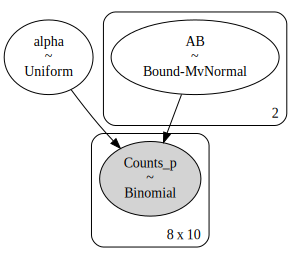

In [19]:
original_model = bf.get_bayesian_model(model_type="",Y=Y1,shots=shots,m_gates=m_gates,mu_AB=mu_AB,cov_AB=cov_AB,alpha_ref=alpha_ref)
pm.model_to_graphviz(original_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [AB, alpha]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 66 seconds.


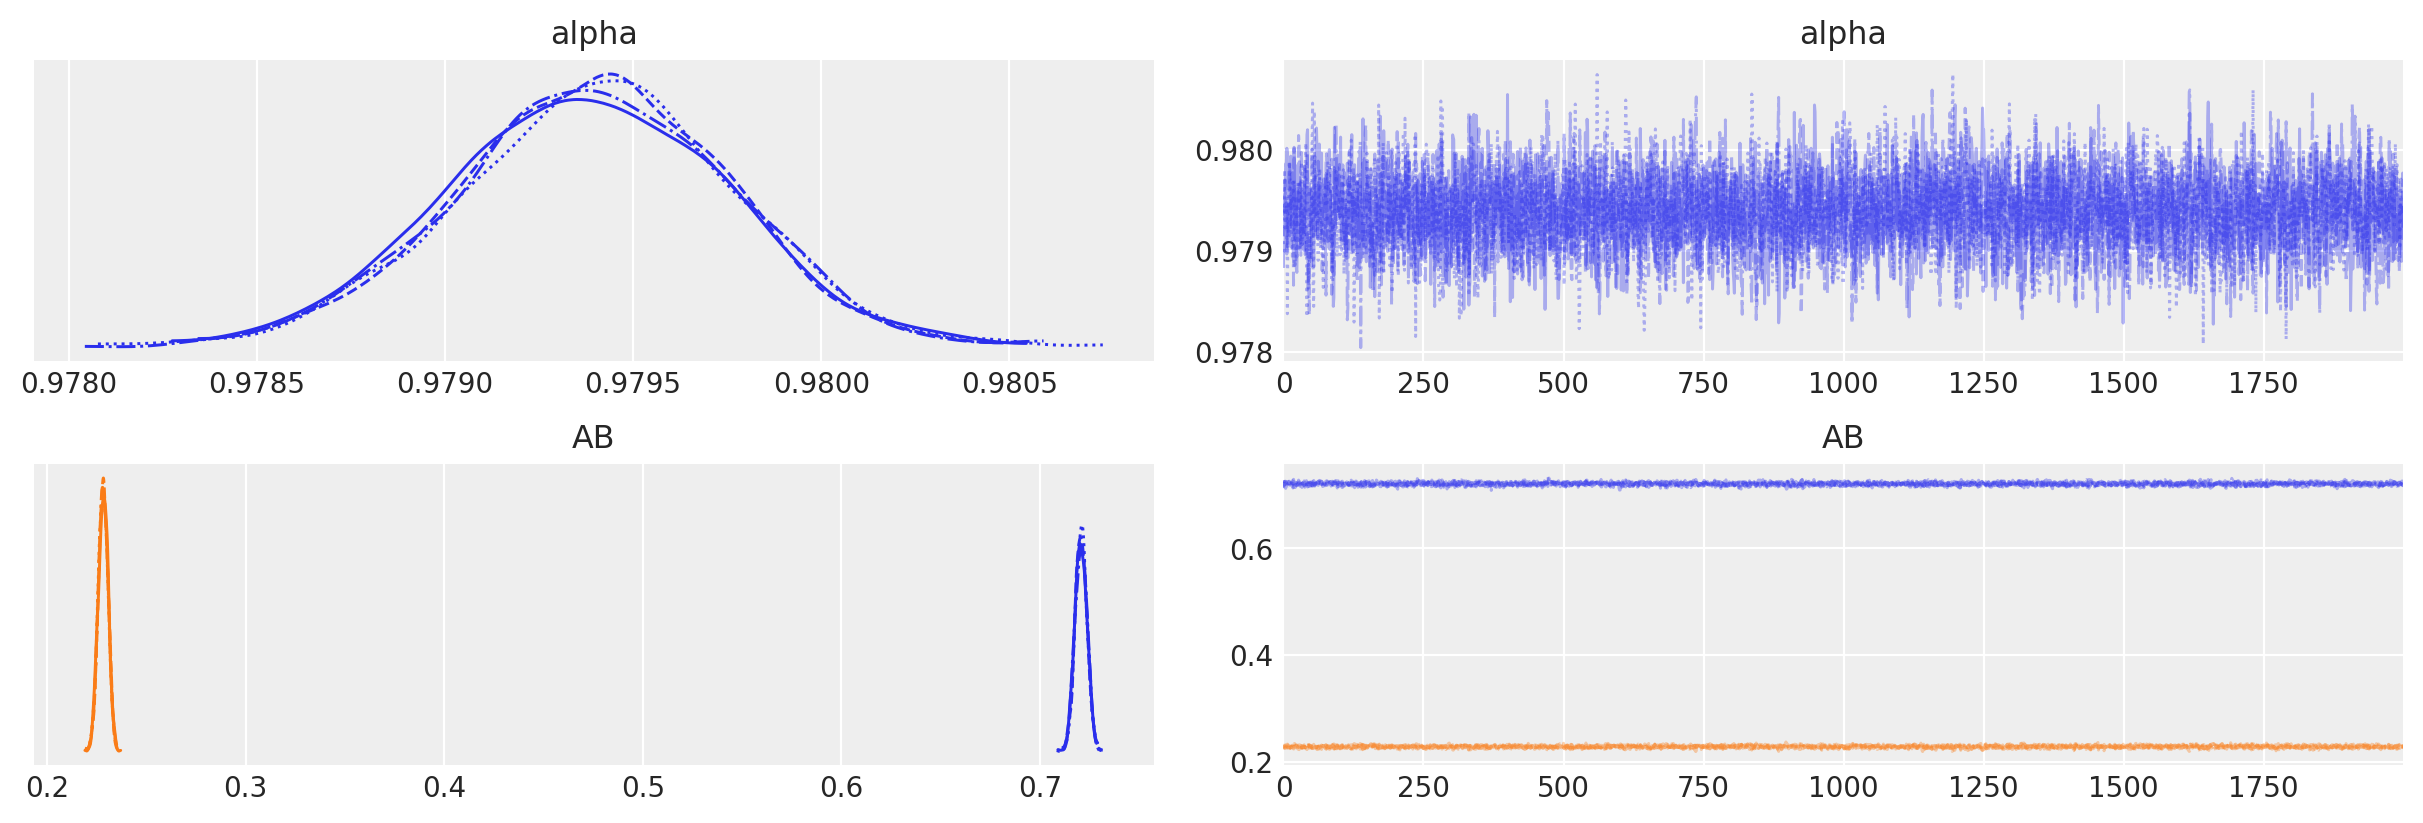

In [20]:
trace_o = bf.get_trace(original_model)

In [21]:
azo_summary = bf.get_summary(original_model, trace_o)
azo_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.9794,0.0004,0.9787,0.9801,0.0,0.0,4299.1386,5180.1471,1.0003
AB[0],0.7208,0.0030,0.7151,0.7263,0.0,0.0,4416.9630,4528.0590,1.0011
AB[1],0.2282,0.0024,0.2235,0.2326,0.0,0.0,3953.7375,3923.5008,1.0003


In [22]:
alpha_original_p = azo_summary['mean']['alpha']
alpha_original_p_err = azo_summary['sd']['alpha']

### Interleaved RB, pooled bayesian model

In [23]:
m_gates, _, alpha_ref, alpha_lower, alpha_upper, mu_AB, cov_AB, sigma_theta =\
    bf.obtain_priors_and_data_from_fitter(rbfit = original_rb_fit, printout = True, nCliffs=nCliffs,shots=shots) 

priors:
alpha_ref 0.9790788258600368
alpha_lower 0.9301248845670349 alpha_upper 1.0
A,B [0.72255886 0.22829485] 
cov A,B [3.16508658e-05 1.64776780e-05]
sigma_theta 0.004


In [24]:
Y2 = bf.get_count_data(interleaved_result_list, nCliffs=nCliffs)

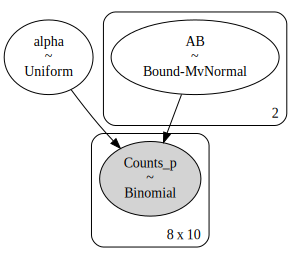

In [25]:
interleaved_model = bf.get_bayesian_model(model_type="pooled",Y=Y2,shots=shots,alpha_ref=alpha_ref,
                                          m_gates=m_gates,mu_AB=mu_AB,cov_AB=cov_AB)
pm.model_to_graphviz(interleaved_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [AB, alpha]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 61 seconds.


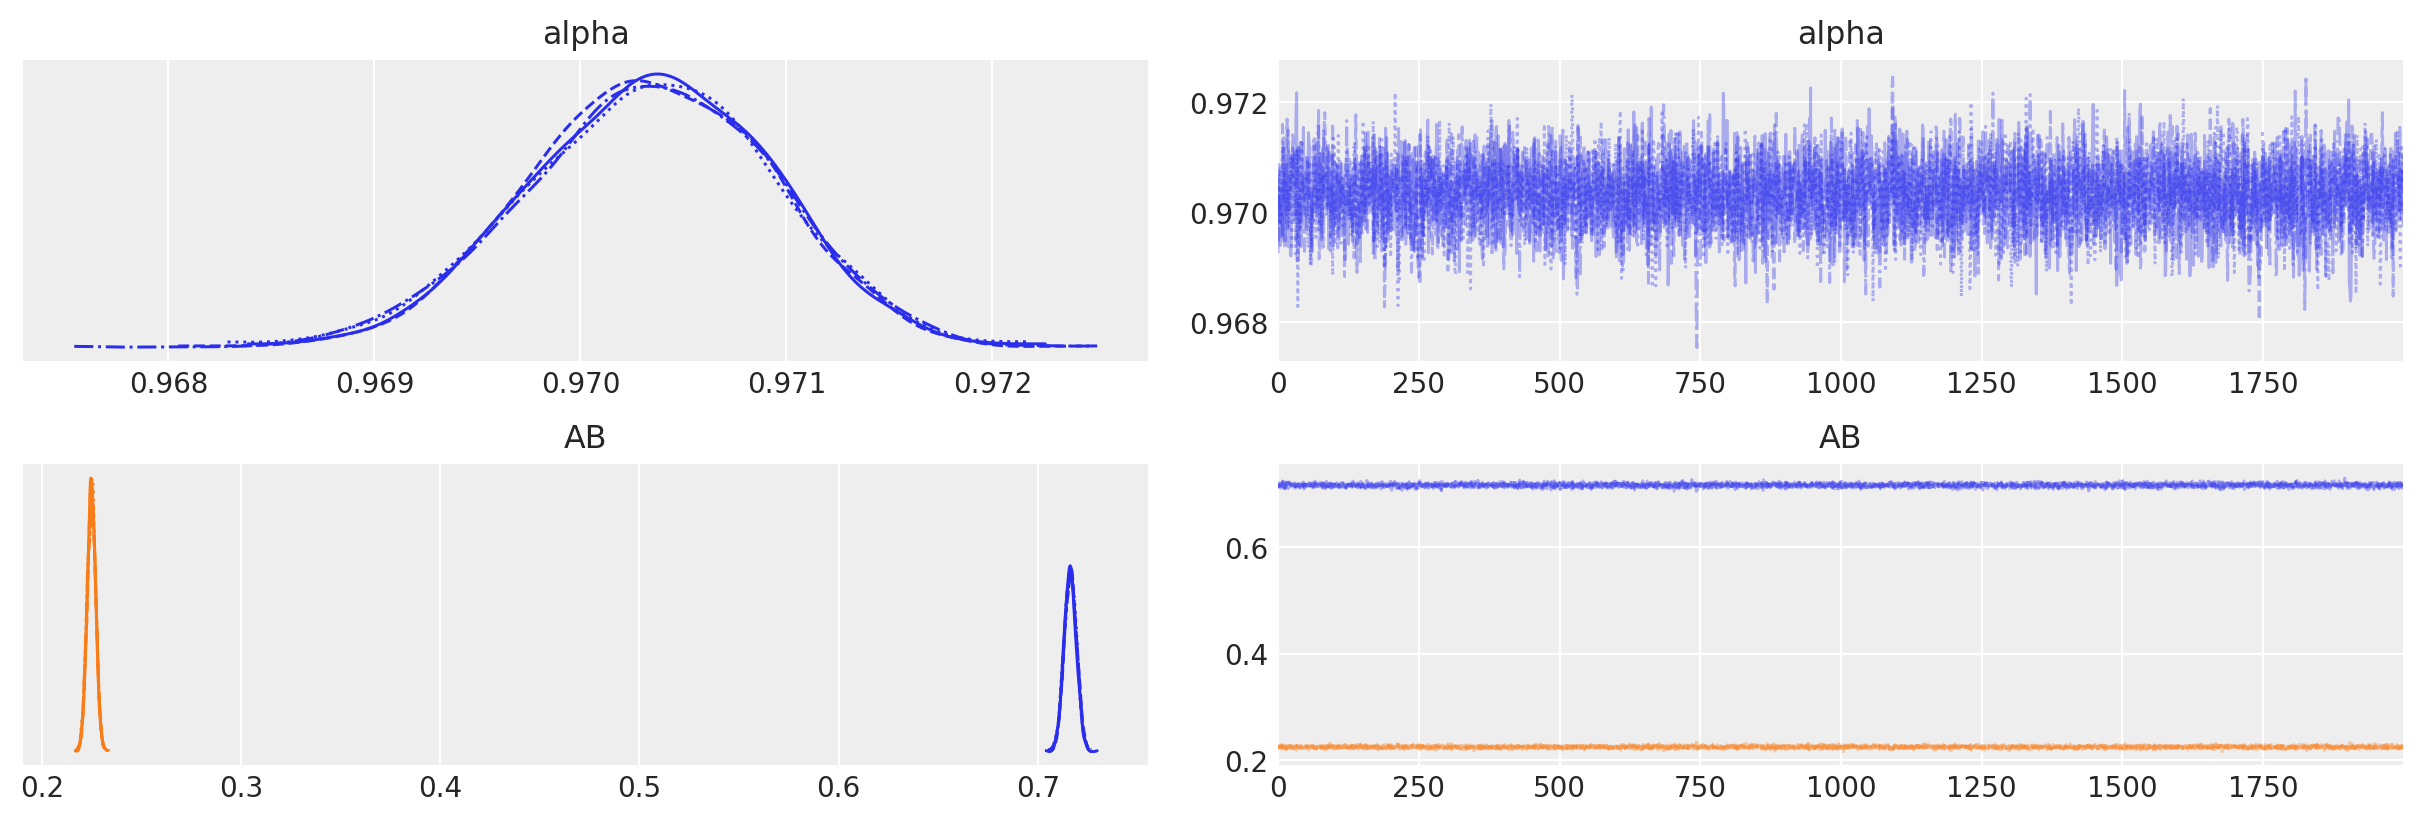

In [26]:
trace_i = bf.get_trace(interleaved_model)

In [27]:
azi_summary = bf.get_summary(interleaved_model, trace_i)
azi_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.9703,0.0006,0.9692,0.9714,0.0,0.0,4946.9259,5107.7815,1.0011
AB[0],0.7164,0.0031,0.7108,0.7222,0.0,0.0,5321.8658,5247.5345,1.0001
AB[1],0.2248,0.0022,0.2207,0.2289,0.0,0.0,5084.6947,5104.6453,0.9999


In [28]:
alpha_c_p = azi_summary['mean']['alpha']
alpha_c_p_err = azi_summary['sd']['alpha']

###  Accelerated RB, pooled bayesian model

model: [equation 5 in this paper](https://arxiv.org/abs/1404.5275) 

In [29]:
m_gates, _, alpha_ref, alpha_lower, alpha_upper, mu_AB, cov_AB, sigma_theta =\
    bf.obtain_priors_and_data_from_fitter(rbfit = original_rb_fit, printout = True,
                                      nCliffs=nCliffs,shots=shots)

priors:
alpha_ref 0.9790788258600368
alpha_lower 0.9301248845670349 alpha_upper 1.0
A,B [0.72255886 0.22829485] 
cov A,B [3.16508658e-05 1.64776780e-05]
sigma_theta 0.004


In [30]:
Y = np.vstack((Y1,Y2))
RvsI = np.vstack((np.ones_like(Y1),np.zeros_like(Y2)))
IvsR = np.vstack((np.zeros_like(Y1),np.ones_like(Y2)))

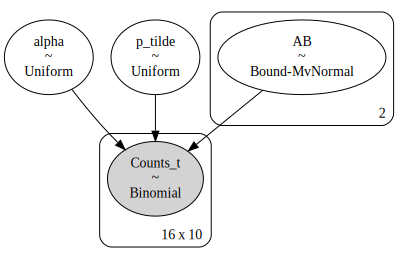

In [31]:
tilde =bf.get_bayesian_model("tilde",Y=Y,shots=shots,m_gates=m_gates,alpha_ref=alpha_ref,
                             mu_AB=mu_AB,cov_AB=cov_AB,RvsI=RvsI,IvsR=IvsR, alpha_upper = 1.0 )
pm.model_to_graphviz(tilde)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_tilde, AB, alpha]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 71 seconds.


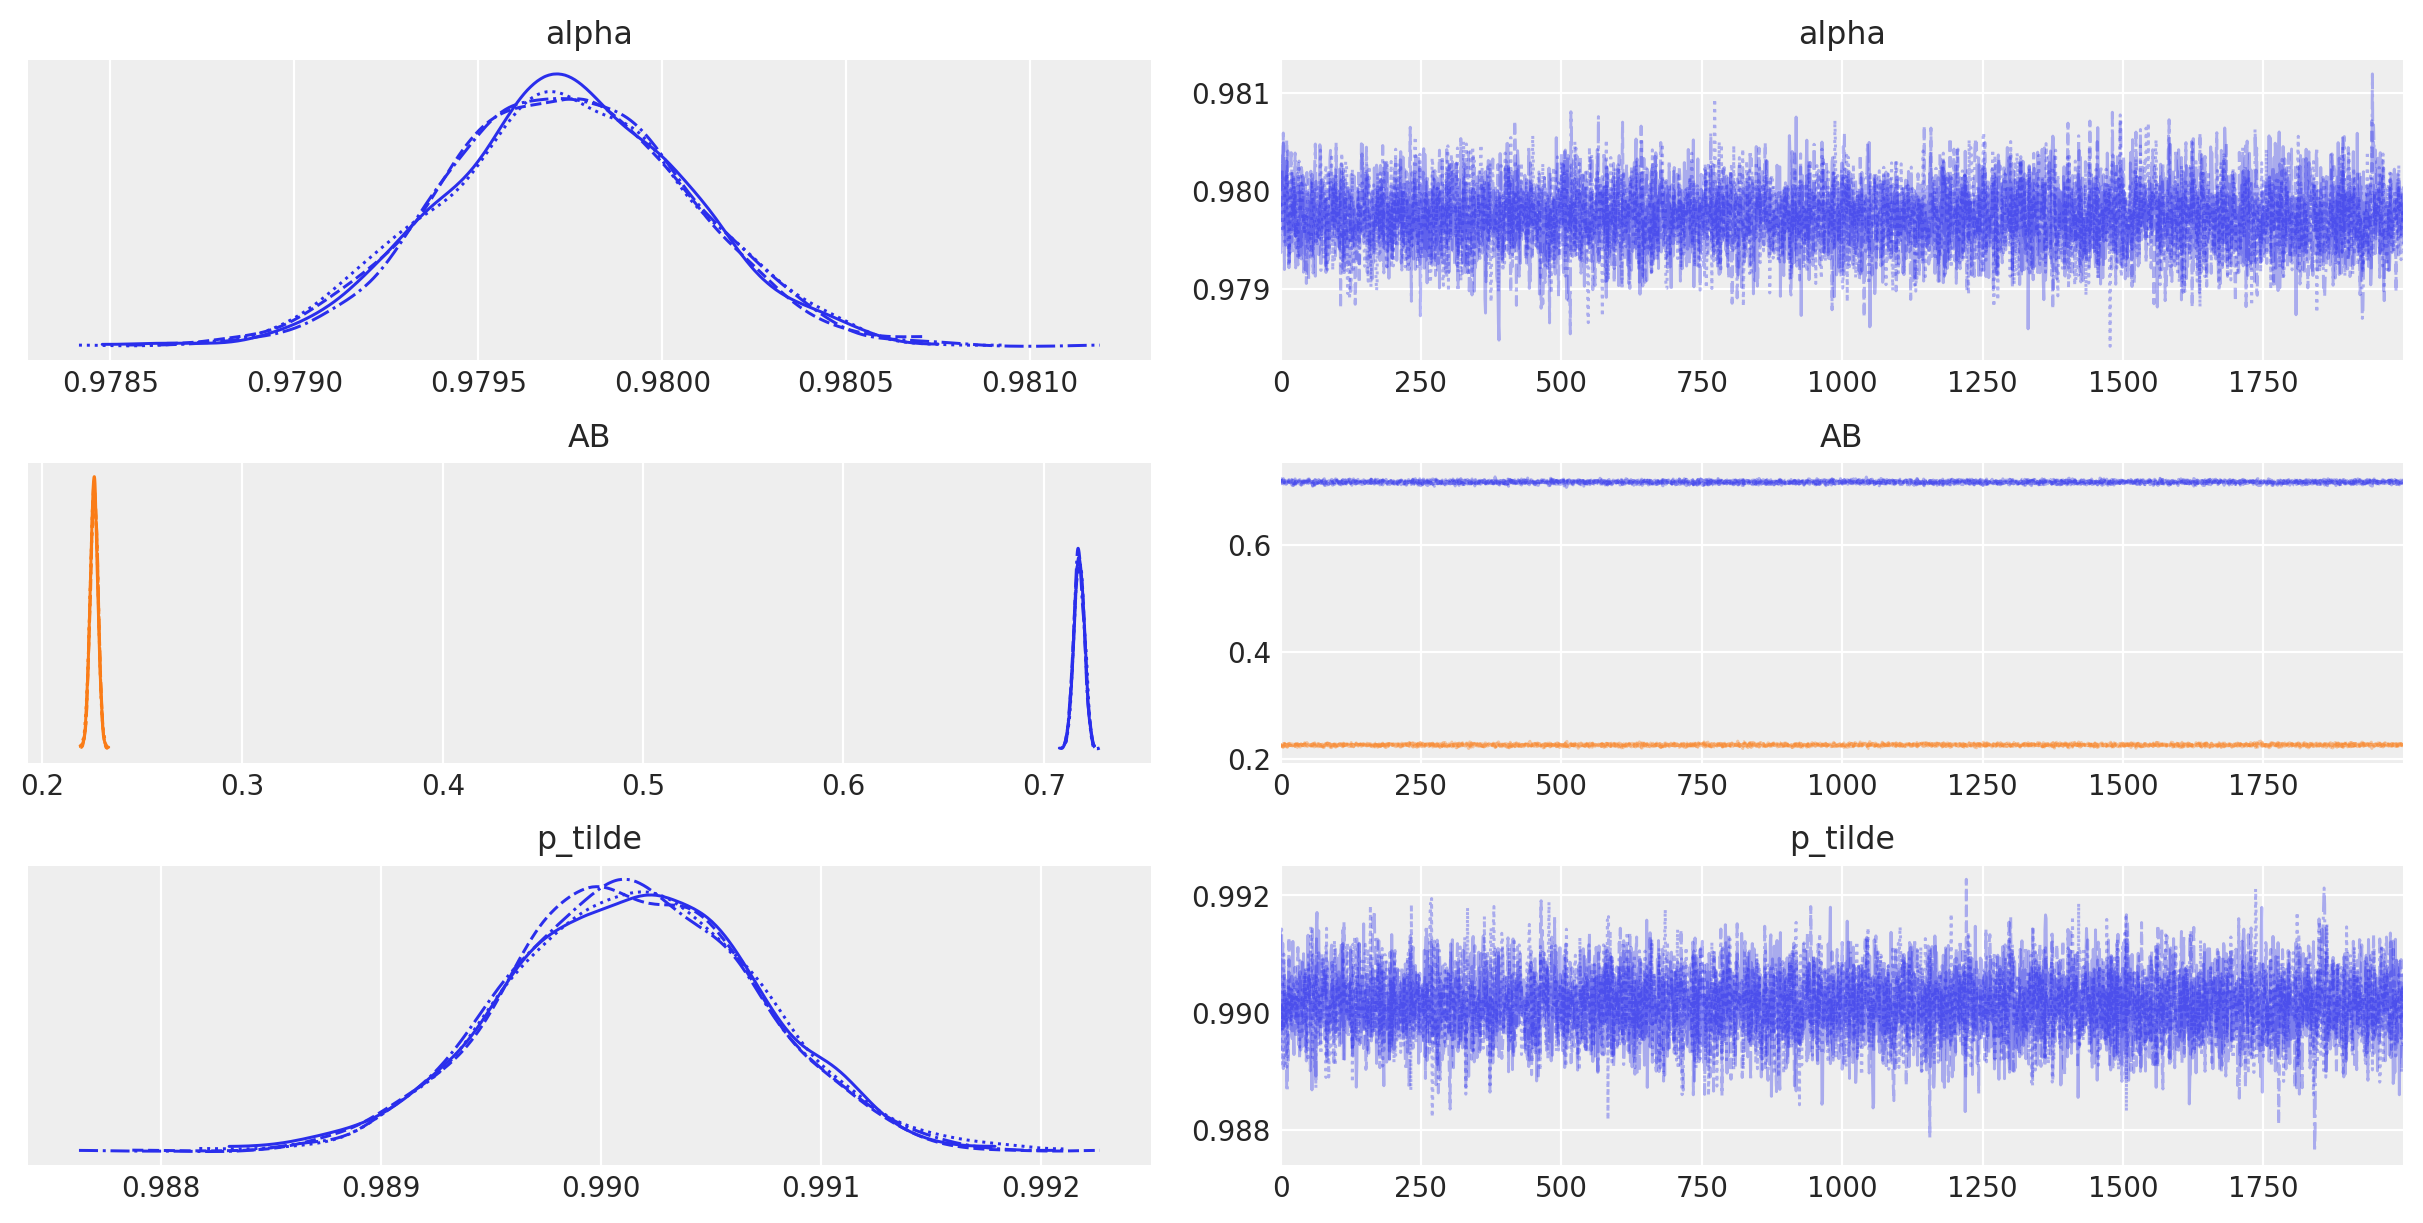

In [32]:
trace_t = bf.get_trace(tilde)

In [33]:
azt_summary = bf.get_summary(tilde, trace_t)
azt_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.9797,0.0003,0.9791,0.9803,0.0,0.0,5826.5270,5416.6570,1.0003
AB[0],0.7176,0.0026,0.7126,0.7224,0.0,0.0,6251.5159,5049.9078,1.0005
AB[1],0.2260,0.0020,0.2223,0.2296,0.0,0.0,5633.6166,5273.0954,1.0009
p_tilde,0.9901,0.0006,0.9891,0.9912,0.0,0.0,6654.9419,5439.9287,1.0008


# Final comparison

In [34]:
epc_calib = 5.430E-3 # enter here the read calibration error of the device, 0.0 if None WIP
epc_est_p = scale*(1 - alpha_c_p/alpha_original_p)
epc_est_p_err = scale*(alpha_c_p/alpha_original_p)*(np.sqrt(alpha_original_p_err**2 + alpha_c_p_err**2))
epc_est_a = scale*(1 - azt_summary['mean']['p_tilde'])
epc_est_a_err = scale* (azt_summary['sd']['p_tilde'])

In [35]:
# compare LSF and SMC
print("Model:     Frequentist             Bayesian")
print("              LSF           two runs    accelerated ")
print("EPC         {0:.5f}         {1:.5f}       {2:.5f}"
      .format(epc_est_f, epc_est_p, epc_est_a, epc_calib))
print("± sigma   ± {0:.5f}       ± {1:.5f}     ± {2:.5f}"
      .format(epc_est_f_err, epc_est_p_err, epc_est_a_err))

Model:     Frequentist             Bayesian
              LSF           two runs    accelerated 
EPC         0.00501         0.00697       0.00743
± sigma   ± 0.00133       ± 0.00054     ± 0.00045


In [36]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright